# **Imports**

In [282]:
import numpy as np 
from SBM import SBM
from simulation_manager import SimulationManager
import results_annalysis

# **Arbitrage reduction**

Defining the reduction 

In [283]:
def permutation_matrix(Size):
    M =np.random.permutation(Size*Size).reshape((Size,Size))
    X = np.array([M[i,j] for i in range(Size) for j in range(Size) ])
    f_X = np.array([M[i,j] for j in range(Size) for i in range(Size) ])
    n = len(X)
    P = np.zeros((n, n), dtype=int)  
    for i in range(n):
        index = np.where(f_X==X[i])[0][0]
        P[index][i] = 1

    return P

In [284]:
def rotation_lignes(Matrix,n): 
    
    for _ in range(n):
        Ligne_0 = Matrix[0,:].copy()
        for i in range(len(Matrix)- 1): 
            Matrix[i,:] = Matrix[i+1,:]

        Matrix[-1,:] = Ligne_0

    return Matrix


def C_rotation(Size): 
    
    c_n = np.zeros((Size,Size))
    for i in range(Size-1): 
        c_n+=rotation_lignes(np.eye(Size),i+1)

    c = np.kron(np.eye(Size), c_n)

    return c

In [285]:
def arbitrage_reduction(Taux,M1 =1,compact=False):
    """
    Input: Exchange rate matrice C
    output: Symmetrical part of J and H  if compact is false 
            else Compact with H integrated and H 
    """
    log_vectorized = np.vectorize(np.log)
    log_Taux = log_vectorized(Taux)
    
    Size = len(log_Taux)
    # Defining the reduction matrices 
    C = C_rotation(Size)
    P = permutation_matrix(Size)

    # Creating H_1

    H_1= -np.array([log_Taux[i,j] for i in range(len(log_Taux)) for j in range(len(log_Taux[0]))])
    I = np.ones(len(H_1))
    
    # Creating J_1
    J_1 = 2*C + 2* P.T@C@P+ 2*np.eye(len(C)) - P - C@P

    H = H_1/2 + M1*(J_1.T+J_1)@I /4
    J = -M1*J_1/2

    # Extract the symmetrical part of J 
    J_sym =(J+J.T)/2 
    np.fill_diagonal(J_sym,0)

    if not compact: 
 # Needs to be verified(Is it necessary?)
        return  J_sym,H
    else: 
        # In here we will follow the methods used in paper 2023
        J_compact = np.zeros((len(J)+1,len(J)+1))
        J_compact[:len(J),:len(J)] = J_sym
        J_compact[:len(J),len(J)] = H 
        J_compact[len(J),:len(J)] = H
        H_compact = np.zeros(len(H)+1)
        # H_compact[:len(H)] = H

        return J_compact,H_compact

# **Simulated bifurcation and result analysis**

We first define the pumping function 

In [286]:
# Defining the rate matrix 

# First test IA generated 
# taux_de_change = [
#     [1.0, 0.8, 0.6, 110, 0.7, 1.2],  # USD
#     [1.25, 1.0, 0.75, 130, 0.9, 1.5], # EUR
#     [1.6, 1.33, 1.0, 180, 1.2, 2.0],  # GBP
#     [0.009, 0.0077, 0.0055, 1.0, 0.0068, 0.011], # JPY
#     [1.43, 1.11, 0.83, 155, 1.0, 1.67], # AUD
#     [0.83, 0.67, 0.5, 91, 0.6, 1.0] ]

taux_de_change  = np.array([
    [1, 0.8, 1.5],
    [1.25, 1, 0.6],
    [0.67, 1.67, 1]
])

In [287]:
# Reduction none compact
J,H  = arbitrage_reduction(taux_de_change)

In [288]:
#Reduction compact
J_compact ,H_compcat  = arbitrage_reduction(taux_de_change,compact = True)

We define the SB parameters

In [289]:
eigs = np.linalg.eigvals(J)
norm_eigs = np.abs(eigs)
ksi = 1/(norm_eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())

step_size = 0.01
num_iterations= 2000
num_simulations= 50
lag = 0 # Remember what the lag is for 

def pumping_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [295]:
manager = SimulationManager(step_size=0.1, num_iterations=num_iterations, num_simulations=2, J=J_compact, H=H_compcat, pumping_rate=pumping_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)

In [303]:
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

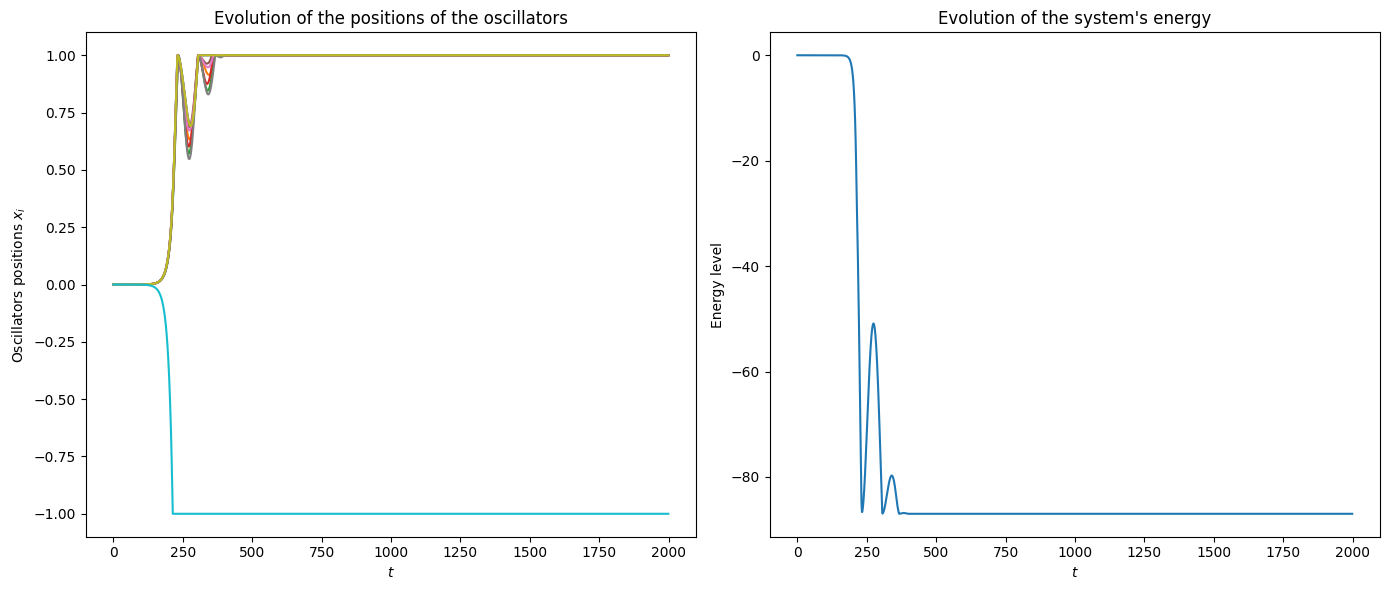

In [297]:
results_annalysis.complete_plot(states, energies, 0)

In [304]:
solution = np.sign(last_states[0, :, 0])

In [305]:
solution

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.])